In [6]:
import psycopg2

# Function to read the db connection info
def read_db_connection_info(filename="../../db_connection_info.txt"):
    connection_info = {}
    with open(filename, 'r') as file:
        for line in file:
            key, value = line.strip().split('=')
            connection_info[key] = value
    return connection_info

# Load the connection info
connection_info = read_db_connection_info()

try:
    # Connect to the database
    conn = psycopg2.connect(
        host=connection_info["host"],
        user=connection_info["user"],
        password=connection_info["password"],
        dbname=connection_info["database"],
        port=connection_info["port"]
    )
    cursor = conn.cursor()

    # Query for total rows
    query_total_rows = """
    SELECT COUNT(*) AS total_rows
    FROM data_mapping
    WHERE ships_idx BETWEEN 1000 AND 1900;
    """
    cursor.execute(query_total_rows)
    total_rows = cursor.fetchone()[0]
    print(f"Total rows where ships_idx is between 1000 and 1900: {total_rows}")

    # Query for distinct ships_idx
    query_distinct_ships_idx = """
    SELECT COUNT(DISTINCT ships_idx) AS distinct_ships_count
    FROM data_mapping
    WHERE ships_idx BETWEEN 1000 AND 1900;
    """
    cursor.execute(query_distinct_ships_idx)
    distinct_ships_count = cursor.fetchone()[0]
    print(f"Distinct ships_idx between 1000 and 1900: {distinct_ships_count}")

    # Close the cursor and connection
    cursor.close()
    conn.close()
    
except Exception as e:
    print(f"An error occurred: {e}")


Total rows where ships_idx is between 1000 and 1900: 62098
Distinct ships_idx between 1000 and 1900: 52


total_count: 62098
mapped_count: 22281
mdm_count: 9817
mapping_rate: 0.3588038262101839
mdm_rate: 0.15808882733743437


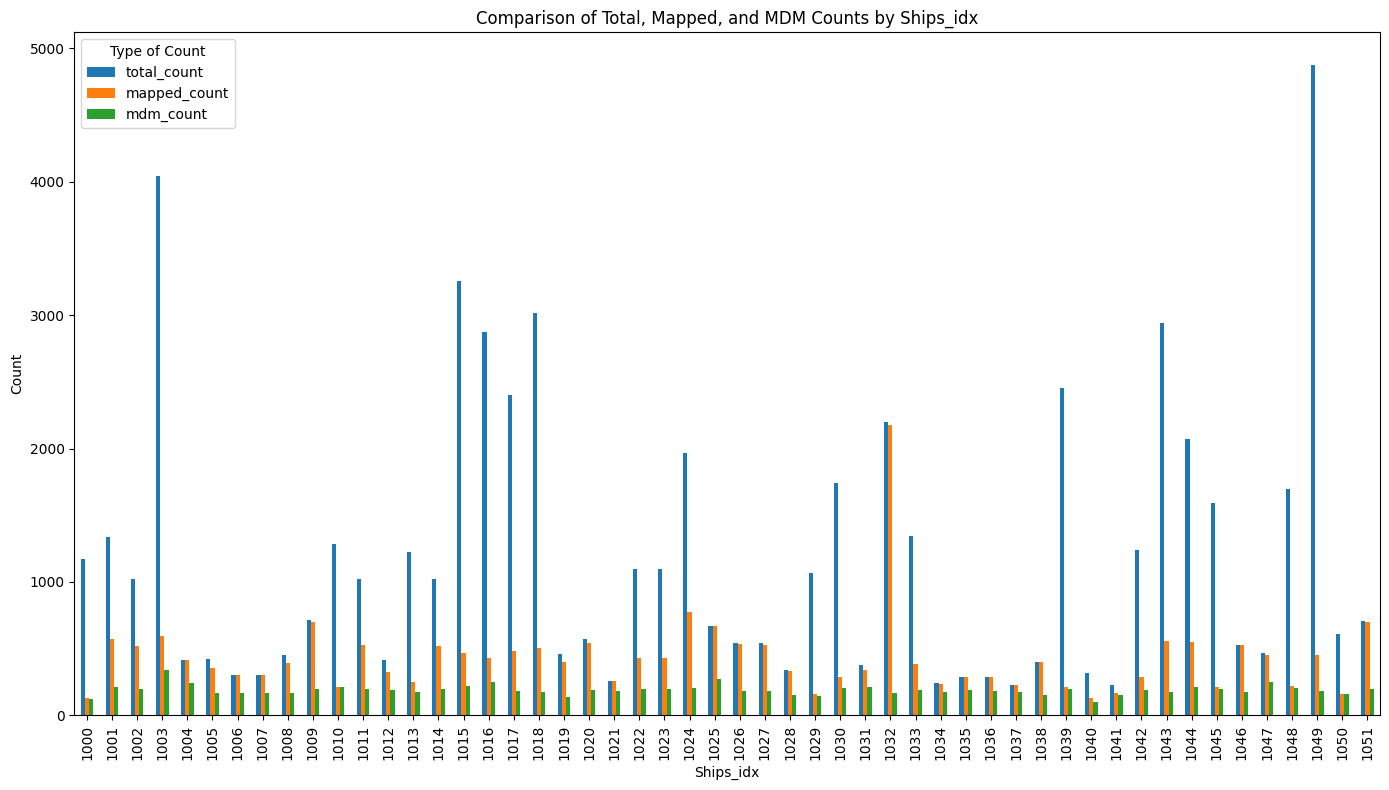

In [7]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

# Assuming connection_info is defined somewhere above this snippet.

try:
    # Connect to the database
    with psycopg2.connect(
        host=connection_info["host"],
        user=connection_info["user"],
        password=connection_info["password"],
        dbname=connection_info["database"],
        port=connection_info["port"]
    ) as conn:
        with conn.cursor() as cursor:
            # SQL query to compute counts grouped by ships_idx including complex pattern matching
            query = """
            SELECT dm.ships_idx,
                   COUNT(*) AS total_count,
                   COUNT(CASE WHEN dm.thing != '$UNMAPPED' THEN 1 END) AS mapped_count,
                   COUNT(CASE 
                            WHEN EXISTS (
                                SELECT 1 FROM data_model_master dmm
                                WHERE dm.thing ~ REPLACE(dmm.thing, '#', '[0-9]+')
                                  AND dm.property ~ REPLACE(dmm.property, '#', '[0-9]+')
                            )
                            THEN 1 
                        END) AS mdm_count
            FROM data_mapping dm
            WHERE dm.ships_idx BETWEEN 1000 AND 1900
            GROUP BY dm.ships_idx
            ORDER BY dm.ships_idx;
            """
            cursor.execute(query)

            # Fetch results into DataFrame
            df = pd.DataFrame(cursor.fetchall(), columns=['ships_idx', 'total_count', 'mapped_count', 'mdm_count'])

            # Calculate total sums
            total_sum_total_count = df['total_count'].sum()
            total_sum_mapped_count = df['mapped_count'].sum()
            total_sum_mdm_count = df['mdm_count'].sum()

            # Print the total sums
            print(f"total_count: {total_sum_total_count}")
            print(f"mapped_count: {total_sum_mapped_count}")
            print(f"mdm_count: {total_sum_mdm_count}")
            print(f"mapping_rate: {total_sum_mapped_count / total_sum_total_count}")
            print(f"mdm_rate: {total_sum_mdm_count / total_sum_total_count}")

            # Plotting
            df.set_index('ships_idx').plot(kind='bar', figsize=(14, 8))
            plt.title('Comparison of Total, Mapped, and MDM Counts by Ships_idx')
            plt.xlabel('Ships_idx')
            plt.ylabel('Count')
            plt.legend(title='Type of Count')
            plt.tight_layout()
            plt.show()

except Exception as e:
    print(f"An error occurred: {e}")
